#### Parton Shower

In [2]:
from random import * 
import math 
import numpy as np 
import scipy 
from scipy import optimize
from matplotlib import pyplot as plt
from tqdm import tqdm 
from scipy.integrate import quad # for numerical integrals
from alphaS import * 


Inizializzo $\alpha_S$ passando come riferimento la massa dello Z

In [3]:
aS=alphaS(0.118,91.186)

In [4]:
# RUN OPTIONS: parametri fondamentali

# Numero di linee di quark da simulare

Nevolve = 100000

# scala del cutoff
Qc = 1.

# the hard scale, e.g. 1000 GeV
Q = 1000.

Nel codice originale veniva data la possibilità di usare $\alpha_S(Q)$ fissa. Questo generava un numero troppo basso di emissioni, cosa non fisica. Quindi ho tolto questa possibilità dal codice.

Definiamo:

- La splitting function, $P(z) = C_F \frac{1+z^2}{1-z}$, given by ```Pqq(z)```,
- La sovrastima per la splitting function $\hat{P} = C_F\frac{2}{1-z}$, given by ```Pqq_over(z)```,
- Il momento trasverso del gluone/quark $p_T^2=z^2(1-z)^2t$
- La massa virtuale del quark iniziale $m^2=z(1-z)t$

- La funzione che ritorna $\alpha_S(p_T)$, ```alphaS```,
- La funzione che ritorna la sovrastima di $\alpha_S$, $\hat{\alpha}_S=\alpha_S(Q_c)$, ```get_alphaS_over```. 

In [5]:
def Pqq(z):
    return CF*(1.+z**2)/(1.-z)

def Pqq_over(z):
    return 2*CF/(1.-z)

# calculate the transverse momentum of the emission

def Get_pTsq(t, z): 
    return z**2 * (1-z)**2 * t

# calculate the virtual mass-squared of the emitting particle

def Get_mvirtsq(t,z): 
    return z*(1-z) * t

def alphaS(t, z):

    scale= z * (1-z) * math.sqrt(t)
    
    if scale < Qc:
        return aS.alphasQ(Qc)/2./math.pi
    
    return aS.alphasQ(scale)/2./math.pi


def get_alphaS_over():
    
    scale = Qc # the minimum scale^2 available 
    alphaS_over = aS.alphasQ(scale)/2./math.pi
    
    return alphaS_over

Definiamo anche

- La funzione $t \times \hat{\Gamma}(z) = \int_{\hat{z}_-}^{\hat{z}^+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z)=\int_{\hat{z}_-}^{\hat{z}^+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} C_F \frac{2}{1-z} =\frac{\hat{\alpha_S}}{2\pi} 2 C_F \log(\frac{1-\hat{z}^-}{1+\hat{z}^+})$, data da```tGamma```.

  In realtà tGamma mi da $t \times \hat{\Gamma}(z) = \int_{}^{z} \mathrm{d} z' \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z')=\int_{}^{z} \mathrm{d} z' \frac{\hat{\alpha_S}}{2\pi} C_F \frac{2}{1-z'}=-\frac{\hat{\alpha_S}}{2\pi} 2 C_F \log(1-z)$
- L'inversa della funzione $t \times \hat{\Gamma}(z)$, data da ```inversetGamma```,
- Le sovrastime  dei limiti di integrazione  $\hat{z}_-$ and $\hat{z}_+$, dati da ```zm_over``` e ```zp_over```:

  $\hat{z}_+(t)=1-\sqrt{\frac{Q_c^2}{t}}$

  $\hat{z}_-(t)=\sqrt{\frac{Q_c^2}{t}}$


In [6]:
def tGamma(z):
    return -2*get_alphaS_over()*CF*np.log(1.-z)

def Inverse_tGamma(y):
     return 1. - np.exp(- 0.5*y/CF/get_alphaS_over())

def zp_over(t):
    return 1-np.sqrt(Qc**2/t)
def zm_over(t):
    return np.sqrt(Qc**2/t)




def Get_zEmission(t,R):
    return Inverse_tGamma(tGamma(zm_over(t))+R*( tGamma(zp_over(t))-tGamma(zm_over(t)) ))

def rho(z1,z2):
    return tGamma(z1)-tGamma(z2)

La soluzione dell'algoritmo è la seguente:

La sovrastima della funzione di Sudakov è data da:

$\hat{\Delta}(t, t_\mathrm{max}) = \exp\left\{ - \int^{t_\mathrm{max}}_{t} \mathrm{d}t' \hat{\Gamma} (t') \right\}$,

con:

$\hat{\Gamma} (t') = \frac{1}{t'}   \int_{\hat{z}_-}^{\hat{z}^+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z)$.

We are working with the overestimated functions, and this allows us to analytically solve:

$\hat{\Delta}(t, t_\mathrm{max}) = R$, 

where $R$ is a random number in $[0,1]$. 

Therefore, we are seeking the solution of:

$\exp\left\{ - \int^{t_\mathrm{max}}_{t} \mathrm{d}t' \hat{\Gamma} (t') \right\} = R$,

or:

$\int^{t_\mathrm{max}}_{t} \mathrm{d}t' \hat{\Gamma} (t') = \ln\left(\frac{1}{R}\right)$.

Definiamo la funzione  $\rho({\hat{z(t')}_+},{\hat{z(t')}_-}) = \int_{\hat{z}_-}^{\hat{z}^+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z) = t'\hat{\Gamma} (t') $, to obtain:

$\int^{t_\mathrm{max}}_{t} \frac{\mathrm{d}t'}{t'} \rho(t') = \ln\left(\frac{1}{R}\right)$, 

or:

$\int^{t_\mathrm{max}}_{t'} \mathrm{d}\ln t' \rho(t) = \ln\left(\frac{1}{R}\right)$.

If the limit overestimates in $\rho({\hat{z}_+},{\hat{z}_-})$ do not depend on $t'$, then: 

$\left. \rho \ln t \right|_t^{t_\mathrm{max}} = \ln\left(\frac{1}{R}\right) \Rightarrow \rho \ln \frac{t_\mathrm{max}}{t}  = \ln\left(\frac{1}{R}\right) $, 

which yields after exponentiation:

$t =  t_\mathrm{max} R^{1/\rho}$.

In the numerical evaluation of $t$, we instead focus on:

$\ln \frac{t}{t_\mathrm{max}} = \frac{1}{\rho} \ln R$,

and construct the function:

$E(t) = \ln \frac{t}{t_\mathrm{max}} - \frac{1}{\rho} \ln R$,

where now, explicitly, $\rho({\hat{z}_+},{\hat{z}_-}) = \int_{\hat{z}_-}^{\hat{z}_+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z) = \int^{\hat{z}_+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z) - \int^{\hat{z}_-} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z)$.

The function ```EmissionScaleFunc``` in the code that follows corresponds to $E(t)$ and the $\rho$ function is calculated via: ```r = tGamma(zp_over(t, Qc), aSover) - tGamma(zm_over(t, Qc), aSover)```. 

The "next" value of $t$ is then calculated by solving $E(t)=0$ in the function ```Get_tEmission```. This is done numerically via ```scipy.optimize.ridder```. 

The ```Get_tEmission``` function actually finds the value of $\ln(t/t_\mathrm{max})$ for which the solution is obtained, and therefore needs to be exponentiated and multiplied by $t_\mathrm{max}$ (represented by ```Q**2```) to get the value of $t$. 

In [7]:
def EmissionScaleFunc(logt_over_Qsq,Q,R):

    t = Q**2 * np.exp( logt_over_Qsq )
    
    r=rho(zp_over(t),zm_over(t))

    return logt_over_Qsq-(1./r)*np.log(R)


def Get_tEmission(Q, tfac,R):

    tolerance = 1E-3 # the tolerance for the solution

    EmissionFunc_arg = lambda x : EmissionScaleFunc(x, Q,R) # the function in a form appropriate for the solver

    # calculate the solution using "Ridder's" method

    lower_bound=np.log(tfac*Qc**2/Q**2)
    upper_bound=0.

    sol, results = scipy.optimize.ridder(EmissionFunc_arg, lower_bound, upper_bound, xtol=tolerance, full_output=True, maxiter=1000)

    tEm = Q**2 * np.exp( sol )

    # if a solution has not been found, terminate the evolution 
    #        
    if abs(EmissionFunc_arg(sol)) > tolerance:
            return Q**2, [], False
            
    # otherwise return the emission scale and continue
    return tEm, results, True

(613806.8199348958,
       converged: True
            flag: 'converged'
  function_calls: 8
      iterations: 3
            root: -0.041787923224764864,
 True)

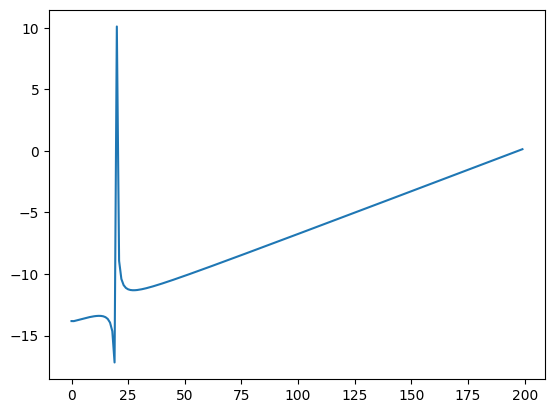

In [8]:
x=np.linspace(math.log(Qc**2/Q**2),0.1,200)
o=0.95
plt.plot(EmissionScaleFunc(x,Q,o))
Get_tEmission(800,3.99,o)


To get the $z$ variable, we need to solve:

$ \rho (z,{\hat{z}_-}) = R' \rho({\hat{z}_+},{\hat{z}_-})$,

where $R'$ is another random number in $[0,1]$. 

Recalling that: 

$t' \hat{\Gamma} (t') = \int_{\hat{z}_-}^{\hat{z}_+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z)$, 

we now define

$\tilde{\rho}(z) = \int^{z} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z)$, we can write the equation for $z$ as:

$\tilde{\rho}(z) - \tilde{\rho}({\hat{z}_-}) = R' \left[ \tilde{\rho}({\hat{z}_+}) - \tilde{\rho}({\hat{z}_-}) \right]$,

and we obtain $z$ by solving:

$ z = \tilde{\rho}^{-1} \left\{ \tilde{\rho}({\hat{z}_-}) + R' \left[\tilde{\rho}({\hat{z}_+}) - \tilde{\rho}({\hat{z}_-}) \right] \right\}$,

where $\tilde{\rho}^{-1}$ is the inverse of $\tilde{\rho}$, which is given by the ```inversetGamma``` function in our code. 

La seguente  funzione ```Generate_Emission``` genera $t$ and $z$ usando le sovrastime , e poi implementa il test di veto construendo la probabilità con la vera splitting function e il valore di $\alpha_S$. 

In [9]:
#
def Generate_Emission(Q, tfac):
    
    generated = True

    R1 = random()
    R2 = random()
    R3 = random() #veto test over z
    R4 = random() #veto test over t
    
    # solve for the (candidate) emission scale:

    tEm, results, continueEvolution = Get_tEmission(Q,tfac,R1)
    
    # if no solution is found then end branch

    if continueEvolution == False:
        zEm = 1.
        pTsqEm = 0.
        MsqEm = 0.
        return tEm, zEm, pTsqEm, MsqEm, generated, continueEvolution

    
    
    # get the (candidate) z of the emission
    zEm = Get_zEmission(tEm,R2)
    
    # get the transverse momentum 
    pTsqEm = Get_pTsq(tEm, zEm)
    # get the virtual mass squared:
    MsqEm = Get_mvirtsq(tEm, zEm)

    # now check the conditions to accept or reject the emission:
    # check if the transverse momentum is physical:
    if pTsqEm < 0.:
      
        generated = False
        
    # compare the splitting function overestimate prob to a random number
    if (Pqq(zEm)/Pqq_over(zEm))*(alphaS(tEm, zEm)/get_alphaS_over()) < R3:
        generated = False
    
    # compare the alphaS overestimate prob to a random number

    #if alphaS(tEm, zEm)/get_alphaS_over() < R4:
    #    generated = False
    
   
    if generated == False: # rejected emission
        zEm = 1.
        pTsqEm = 0.
        MsqEm = 0.
        
    # return all the variables for the emission
    return tEm, zEm, pTsqEm, MsqEm, generated, continueEvolution

The above function generates the next emission scale and momentum fraction. To get the full evolution, the main function uses it, until the cutoff scale is reached. 

Note that the next evolution scale is set to $\tilde{t} z^2$ in order to implement angular ordering in the branchings

In [10]:
# the function that performs the evolution of a single branch:
# returns a list of all the emissions for further processing

def Evolve(Q):
    # the minimum evolution scale
    tEm_min = Qc**2
    # counter for the number of emissions:
    Nem = 0
    # array to store emission info:
    Emissions = []

    fac_tEm = 3.999 # minimum value for the cutoff to try emissions = fac_tEm * Qc**2 (should be less than the actual cutoff)
    fac_cutoff = 4. # actual cutoff = fac_cutoff * Qc**2

    # start the evolution

    tEm = Q**2 # initial value of the evolution variable
    zEm = 1    # initial value of the momentum fraction

    

    while np.sqrt(tEm)*zEm > np.sqrt(fac_cutoff*tEm_min):

        # evolve:
        tEm, zEm, pTsqEm, MsqEm, generatedEmission, continueEvolution = Generate_Emission(np.sqrt(tEm)*zEm, fac_tEm)

        # if the solver could not find a solution, end the evolution
        if continueEvolution == False:
           return Emissions
           
        # if we have already passed the cutoff this emission does not count
        # this will also terminate the evolution
        if tEm < fac_cutoff*tEm_min: 
           
            zEm = 1.
            pTsqEm = 0.
            QsqEm = 0.
        
            return Emissions

        # if the emission was successful, append to the Emissions list and continue
        if zEm != 1.0:
            
            Emissions.append([math.sqrt(tEm), zEm, math.sqrt(pTsqEm), math.sqrt(MsqEm)])
            Nem = Nem + 1
            
    return Emissions




In [11]:
##########################
# Evolution begins here! #
##########################

# list to store all emission information:
AllEmissions = []
N_Emissions=[]

print('Evolving', Nevolve, 'branches from Q=', Q, 'GeV --> Qc=', Qc, 'GeV')

# perform evolution over Nevolve branches:

for j in tqdm(list(range(Nevolve))): 

    Emissions =Evolve(Q)
    N_Emissions.append(len(Emissions))
  
    # concatenate the emissions of this evolution branch to the list of all emissions to plot
    AllEmissions = AllEmissions + Emissions

print('All evolutions ended')


Evolving 100000 branches from Q= 1000.0 GeV --> Qc= 1.0 GeV


100%|██████████| 100000/100000 [09:51<00:00, 169.14it/s]

All evolutions ended


Distribuzione del numero di emissioni per branch

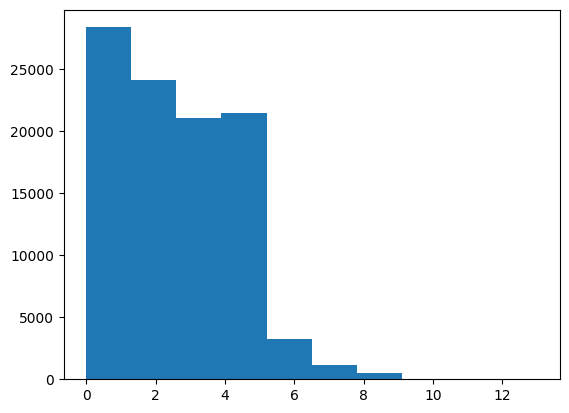

[[483.06832184628956,
  0.9924320243442059,
  3.6281819213157758,
  41.864779374589546],
 [104.94600950968294,
  0.9173672249151297,
  7.955390226998682,
  28.894401852536113],
 [90.75893331381556, 0.9612230452452832, 3.382885179129552, 17.52218737432385],
 [61.51278921562057,
  0.9805623882984063,
  1.1724209033814865,
  8.492283550476447],
 [26.26298688252155, 0.9328826856330625, 1.644393379803616, 6.571657459384782],
 [10.205110360512045,
  0.8383145778958466,
  1.383233787962173,
  3.757133676161003],
 [69.5805421408128, 0.8568754028960999, 8.533353987003435, 24.367096599619035],
 [172.18051458965164,
  0.9938236093388785,
  1.0568858142288788,
  13.489816283272035],
 [47.21155797568123,
  0.7671868509403333,
  8.432512395264654,
  19.952745370742537],
 [7.014825501312885,
  0.6648754461639595,
  1.5630159709597369,
  3.3112360670975547],
 [731.5481309934538,
  0.7806885357949673,
  125.25124210361041,
  302.7000364478088],
 [301.5632334728604,
  0.9953944819252434,
  1.38245852599

In [12]:
plt.hist(N_Emissions)
plt.show()
AllEmissions

---
plotting z of emissions


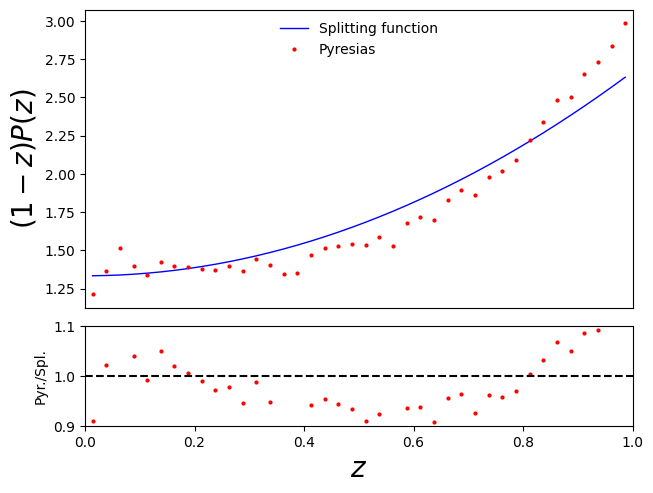

In [13]:
ptarray=[]
marray=[]
zarray = []

for i in range(len(AllEmissions)):
    zarray.append(np.array(AllEmissions[i][1]))
    ptarray.append(np.array(AllEmissions[i][2]))
    marray.append(np.array(AllEmissions[i][3]))


###########################
print('---')
print('plotting z of emissions')
# plot settings ########

plot_type = 'splitting'
# plot:
# plot settings
ylab = '$(1-z)P(z)$'
xlab = '$z$'

nbins=40
# construct the axes for the plot
fig = plt.figure(constrained_layout=True)

import matplotlib.gridspec as gridspec # more plotting 


gs = gridspec.GridSpec(4, 4,figure=fig,wspace=0, hspace=0)

ax = fig.add_subplot(gs[:3, :])
ax2 = fig.add_subplot(gs[3, :])


# get the histogram bins:

bins, edges = np.histogram(zarray, bins=nbins, density=True)

left,right = edges[:-1],edges[1:]

X = np.array([0.5*left+0.5*right]).T.flatten()
Y = np.array([bins]).T.flatten() * (1-X)
# normalise:
xnorm_min=0.0
xnorm_max=1.0

# compare to the input splitting function
# this comparison is only correct if alphaS is fixed
# this is because the scale of alphaS is also a function of z 
Yspl = Pqq(X) * (1-X)

# get the integral numerically, but not in the whole range
# since the splitting function diverges as z->1 and this cannot be captured numerically:
zp = X[(X<xnorm_max)][-1]
zm = X[(X>xnorm_min)][0]

def Pqq1mz(z):
    return Pqq(z) * (1-z)
YsplI = quad(Pqq1mz, 0, 1)
YsplI = np.linalg.norm(Yspl)

ax.plot(X,Yspl, color='blue', lw=1, label='Splitting function', marker='x', ms=0)

# plot:

Y = YsplI * Y / np.linalg.norm(Y)


ax.plot(X,Y, label='Pyresias', color='red', lw=0, marker='o', ms=2)

# ratio:
ax2.plot(X,Y/Yspl, color='red', lw=0, label='Splitting function', marker='o', ms=2)
ax2.hlines(y=1, xmin=0, xmax=1, color='black', ls='--')

# set the ticks, labels and limits etc.
ax.set_ylabel(ylab, fontsize=20)
ax2.set_xlabel(xlab, fontsize=20)
ax2.set_ylabel('Pyr./Spl.')
ax2.set_ylim(0.9,1.1)
ax2.set_xlim(0.0,1.0)
ax.set_xlim(0.0,1.0)


# create legend and plot/font size
ax.legend()
ax.legend(loc="upper center", numpoints=1, frameon=False, prop={'size':10})
ax.set_xticklabels('')
ax.set_xticks([])

infile = plot_type + '.dat'
plt.savefig('plots/' + infile.replace('.dat','.pdf'), bbox_inches='tight')


Welcome to JupyROOT 6.26/06


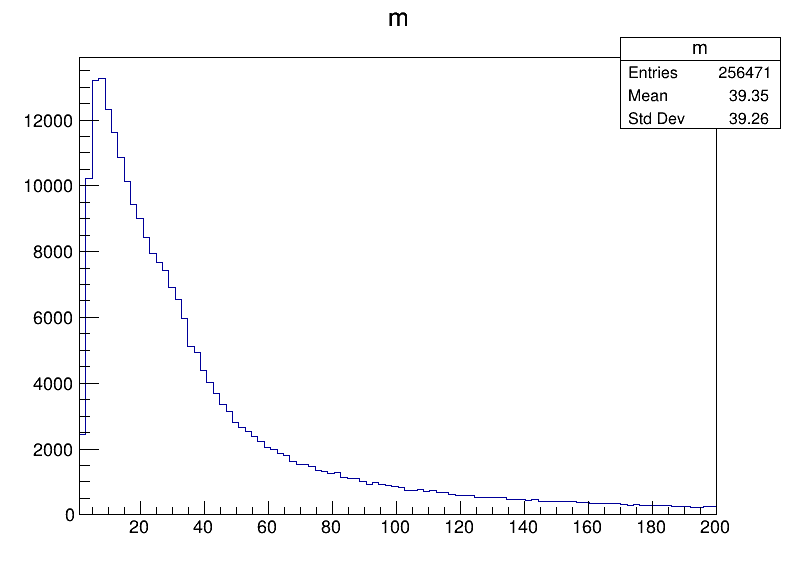

In [14]:
import ROOT

histogram_pt= ROOT.TH1D("pT", "pT", 100,Qc,30)
histogram_m=  ROOT.TH1D("m", "m", 100,Qc,200)

for i in range(len(AllEmissions)):
    histogram_pt.Fill(ptarray[i])
    histogram_m.Fill(marray[i])


# Creare un canvas per disegnare l'istogramma
canvas = ROOT.TCanvas("canvas", "Canvas", 800, 600)

# Mostrare il canvas con l'istogramma
canvas.Update()
canvas.Draw()
histogram_m.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


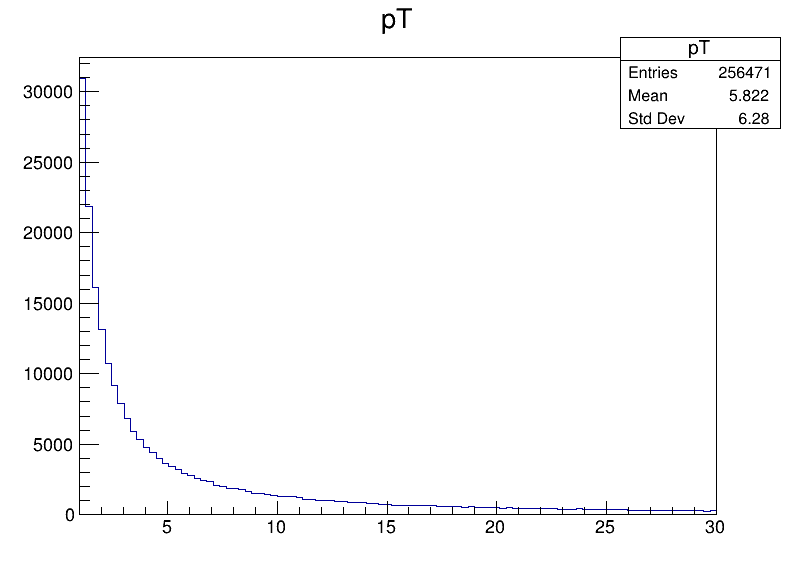

In [15]:
canvas = ROOT.TCanvas("canvas", "Canvas", 800, 600)

# Disegnare l'istogramma
histogram_pt.Draw()
# Mostrare il canvas con l'istogramma
canvas.Update()
canvas.Draw()



In [16]:
pt1500=[]
pt1000=[]
pt500=[]
pt200=[]

All1500=[]
All1000=[]
All500=[]
All200=[]


for j in tqdm(list(range(Nevolve))):

    Emissions1500 =Evolve(1500)
    Emissions1000 =Evolve(1000)
    Emissions500 = Evolve(500)
    Emissions200 = Evolve(200)

    All1500 = All1500 + Emissions1500
    All1000 = All1000 + Emissions1000
    All500 = All500 + Emissions500
    All200 = All200 + Emissions200


100%|██████████| 100000/100000 [39:16<00:00, 42.44it/s]


In [55]:
Qmax=5
hist1500=ROOT.TH1D("hist1500","hist1500",100,Qc,Qmax)
hist1000=ROOT.TH1D("hist1000","hist1000",100,Qc,Qmax)
hist500=ROOT.TH1D("hist500","hist500",100,Qc,Qmax)
hist200=ROOT.TH1D("hist200","hist200",100,Qc,Qmax)


Warning in <TROOT::Append>: Replacing existing TH1: hist1500 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist1000 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist500 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist200 (Potential memory leak).


In [56]:
for i in range(len(All1500)):
    hist1500.Fill(All1500[i][2])

for i in range(len(All1000)):
    hist1000.Fill(All1000[i][2])
    
for i in range(len(All500)):
    hist500.Fill(All500[i][2])

for i in range(len(All200)):
    hist200.Fill(All200[i][2])


Info in <TCanvas::Print>: png file pT_Pyresias.png has been created


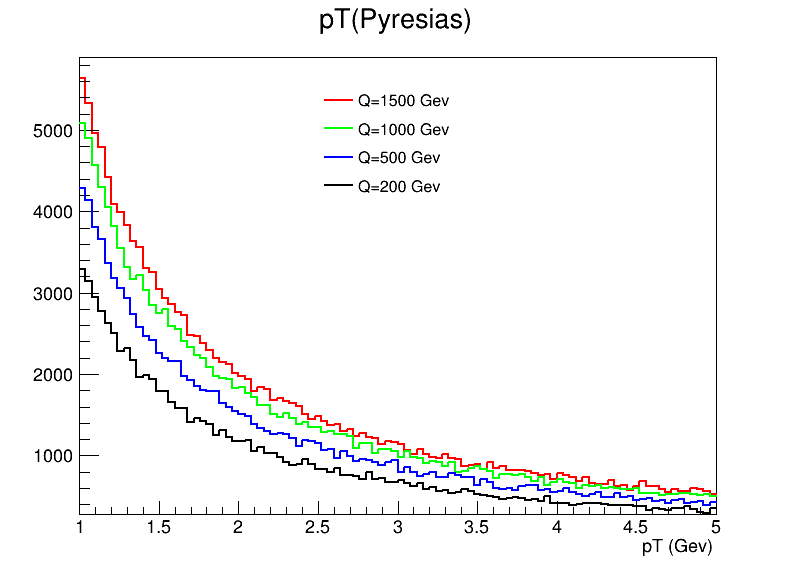

In [62]:
hist1500.SetLineColor(ROOT.kRed)
hist1000.SetLineColor(ROOT.kGreen)
hist500.SetLineColor(ROOT.kBlue)
hist200.SetLineColor(ROOT.kBlack)


leg = ROOT.TLegend(0.4, 0.65, 0.6,0.85);
leg.SetLineColor(0)
leg.AddEntry(hist1500, "Q=1500 Gev", "l");
leg.AddEntry(hist1000, "Q=1000 Gev", "l");
leg.AddEntry(hist500, "Q=500 Gev", "l");
leg.AddEntry(hist200, "Q=200 Gev", "l");
hist1500.GetXaxis().SetTitle("pT (Gev)")
hist1500.SetLineWidth(2)
hist1000.SetLineWidth(2)
hist500.SetLineWidth(2)
hist200.SetLineWidth(2)
hist1500.SetTitle("pT(Pyresias)")
'''  
hist1500.Scale(1/hist1500.GetEntries())
hist1000.Scale(1/hist1000.GetEntries())
hist500.Scale(1/hist500.GetEntries())
hist200.Scale(1/hist200.GetEntries())
'''
# Disegnare l'istogramma
hist1500.Draw()
hist1000.Draw("SAME")
hist500.Draw("SAME")
hist200.Draw("SAME")
hist1500.SetStats(0)
leg.Draw()

# Mostrare il canvas con l'istogramma
canvas.Update()
canvas.Draw()
canvas.SaveAs("pT_Pyresias.png")

In [63]:
Evolve(1000)

[[631.084907902719, 0.9388197783066125, 36.24775143971034, 151.24618632881376],
 [503.3687629062982, 0.9088687039517107, 41.69221391089772, 144.8673812117598],
 [441.8200507831675,
  0.9953739270644192,
  2.0344365868813616,
  29.980908527445546]]